In [4]:
from dotenv import load_dotenv
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import os

In [5]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

load_dotenv()

True

In [6]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

teusaquillo = apartments.loc[apartments['localidad'] == 'TEUSAQUILLO']
teusaquillo.head()

codigo tipo_propiedad tipo_operacion  precio_venta  area  habitaciones  \
11   2539598    APARTAMENTO          VENTA   480000000.0  70.0           3.0   
46   4253977    APARTAMENTO          VENTA   527400000.0  70.0           3.0   
226  4167860    APARTAMENTO          VENTA   522711000.0  85.0           3.0   
268  4380107    APARTAMENTO          VENTA   185734677.0  25.0           1.0   
442  4255253    APARTAMENTO          VENTA   411500000.0  56.0           2.0   

     banos  administracion  parqueaderos          sector  ...  vigilancia  \
11     2.0             NaN           1.0  QUINTA PAREDES  ...         0.0   
46     2.0        624000.0           1.0        GALERIAS  ...         0.0   
226    2.0         80000.0           0.0  QUINTA PAREDES  ...         0.0   
268    1.0             NaN           0.0        GALERIAS  ...         0.0   
442    2.0        341900.0           1.0        GALERIAS  ...         0.0   

    coords_modified    localidad                barrio  \
11            False  TEUSAQUILLO        QUINTA PAREDES   
46            False  TEUSAQUILLO         BANCO CENTRAL   
226           False  TEUSAQUILLO           EL_RECUERDO   
268           False  TEUSAQUILLO         ALFONSO LOPEZ   
442           False  TEUSAQUILLO  CHAPINERO OCCIDENTAL   

                          estacion_tm_cercana distancia_estacion_tm_m  \
11                                  Corferias                  271.23   
46                                      Marly                  438.14   
226  Ciudad Universitaria - Lotería de Bogotá                  433.15   
268                                     Marly                  461.14   
442                                  Calle 63                  286.62   

    is_cerca_estacion_tm                                   parque_cercano  \
11                     1                       PARQUE VECINAL SANTA CLARA   
46                     1  PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD   
226                    1                       PARQUE VECINAL SANTA CLARA   
268                    1  PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD   
442                    1                  PARQUE ZONAL GIMNASIO DEL NORTE   

    distancia_parque_m is_cerca_parque  
11              601.46               0  
46             1134.61               0  
226            1224.87               0  
268            1205.18               0  
442            1212.41               0  

[5 rows x 45 columns]

In [7]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
# teusaquillo =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'TEUSAQUILLO') & (apartments['coords_modified'] == False)]
# teusaquillo = teusaquillo.drop(columns=['precio_arriendo'])
# teusaquillo.head()

In [8]:
teusaquillo.datetime = pd.to_datetime(teusaquillo.datetime)
teusaquillo['last_view'] = pd.to_datetime(teusaquillo['last_view'])

In [10]:
teusaquillo.shape

(738, 45)

In [11]:
teusaquillo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738 entries, 11 to 43010
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   codigo                   738 non-null    object        
 1   tipo_propiedad           738 non-null    object        
 2   tipo_operacion           738 non-null    object        
 3   precio_venta             738 non-null    float64       
 4   area                     738 non-null    float64       
 5   habitaciones             738 non-null    float64       
 6   banos                    738 non-null    float64       
 7   administracion           642 non-null    float64       
 8   parqueaderos             738 non-null    float64       
 9   sector                   723 non-null    object        
 10  estrato                  738 non-null    float64       
 11  antiguedad               738 non-null    object        
 12  latitud                  738 non-null 

In [12]:
teusaquillo.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')

In [13]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

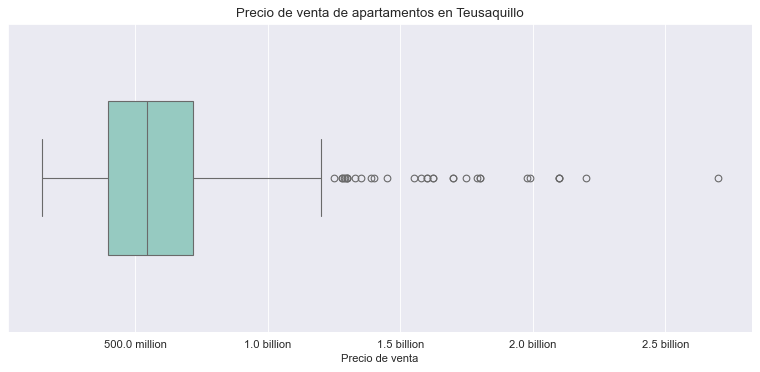

In [14]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    teusaquillo,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Teusaquillo')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [15]:
Q1 = teusaquillo['precio_venta'].quantile(0.25)
Q3 = teusaquillo['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = teusaquillo[(teusaquillo['precio_venta'] < lower) | (teusaquillo['precio_venta'] > upper)]
outliers.shape

(76, 45)

In [16]:
teusaquillo = teusaquillo[(teusaquillo['precio_venta'] > lower) & (teusaquillo['precio_venta'] < upper)]
teusaquillo.shape

(662, 45)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [17]:
# eliminar area igual a 0

teusaquillo = teusaquillo[teusaquillo['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [18]:
Q1 = teusaquillo['area'].quantile(0.25)
Q3 = teusaquillo['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = teusaquillo[(teusaquillo['area'] < lower) | (teusaquillo['area'] > upper)]
outliers.shape

(15, 45)

In [19]:
teusaquillo = teusaquillo[(teusaquillo['area'] > lower) & (teusaquillo['area'] < upper)]
teusaquillo.shape

(646, 45)

### Analisis

In [20]:
teusaquillo.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

count               mean                std   min   25%  \
area  646.0  85.82780185758514  30.90119844339695  4.93  63.0   

                    50%       75%    max  
area  83.99000000000001  106.8575  178.0

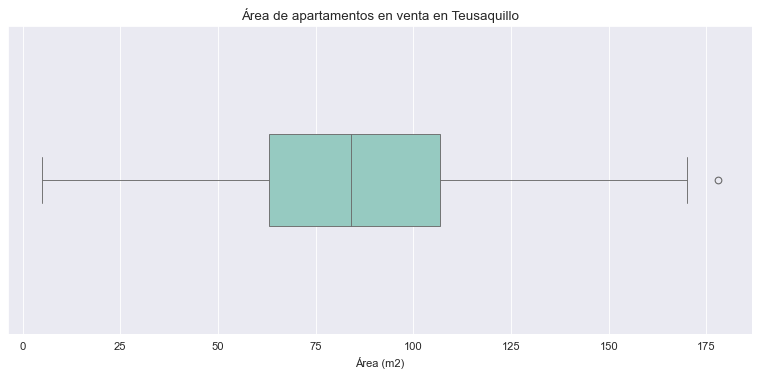

In [21]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=teusaquillo,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en venta en Teusaquillo')
plt.xlabel('Área (m2)')
plt.show()

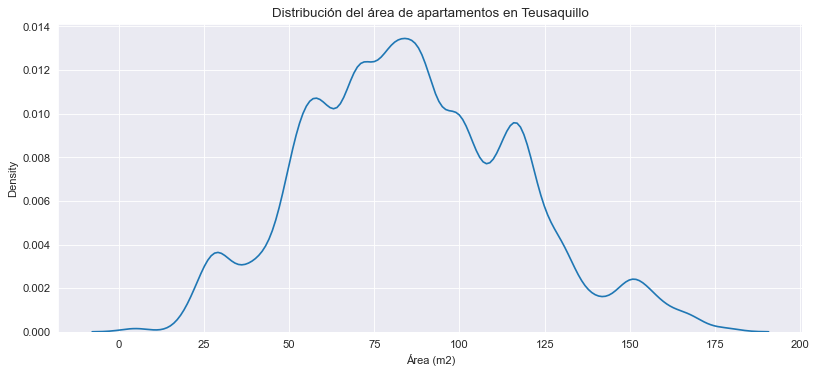

In [22]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en Teusaquillo')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

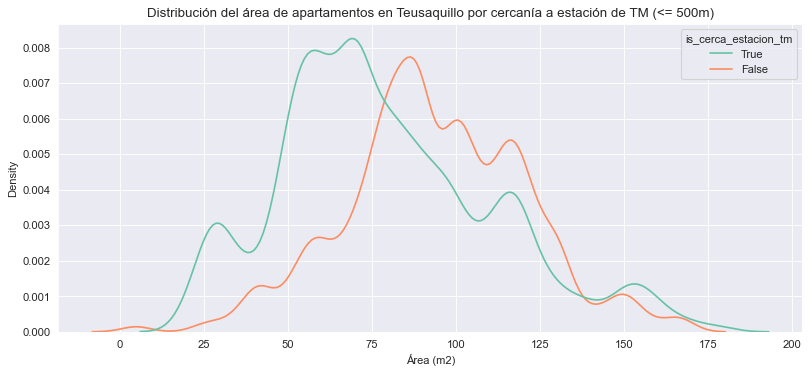

In [23]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en Teusaquillo por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2)')
plt.show()

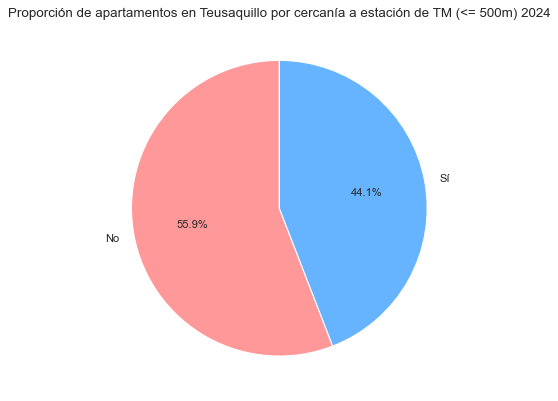

In [25]:
# pie chart

plt.figure(figsize=(6, 6))

teusaquillo['is_cerca_estacion_tm'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff'],
    labels=['No', 'Sí'],
)

plt.title('Proporción de apartamentos en Teusaquillo por cercanía a estación de TM (<= 500m) 2024')
plt.ylabel('')
plt.show()

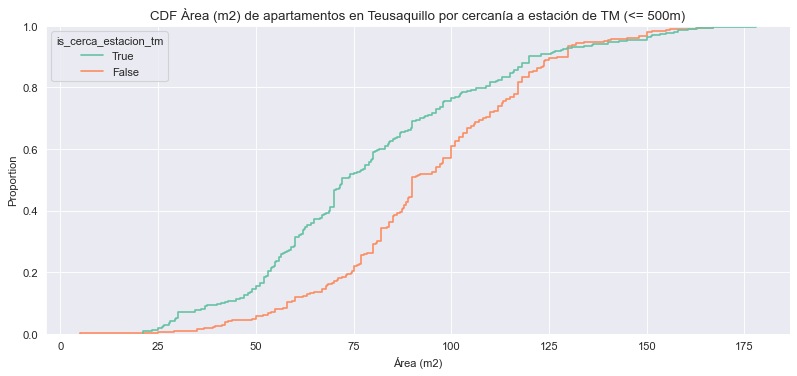

In [26]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    teusaquillo,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en Teusaquillo por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [27]:
teusaquillo.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

count   mean   std   min   25%    50%    75%    max
estrato                                                     
3.0       55.0   68.2  27.0  21.0  53.5   65.0   81.0  167.0
4.0      502.0   85.2  30.9   4.9  62.5   82.0  104.8  178.0
5.0       89.0  100.5  26.6  37.0  85.0  101.0  118.0  163.0

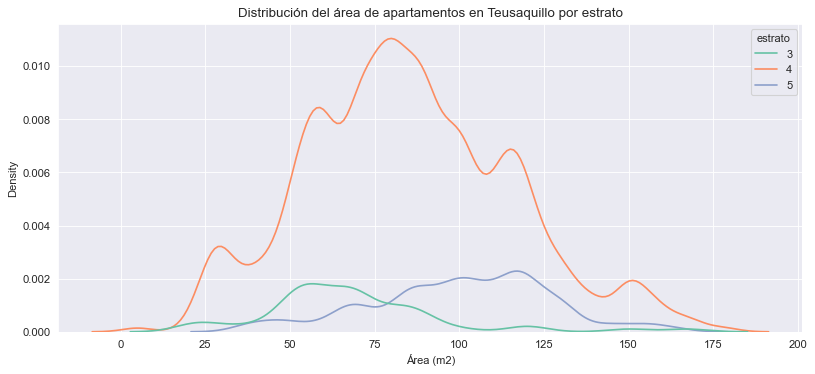

In [28]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='area',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[3, 4, 5],
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Teusaquillo por estrato')
plt.xlabel('Área (m2)')
plt.show()

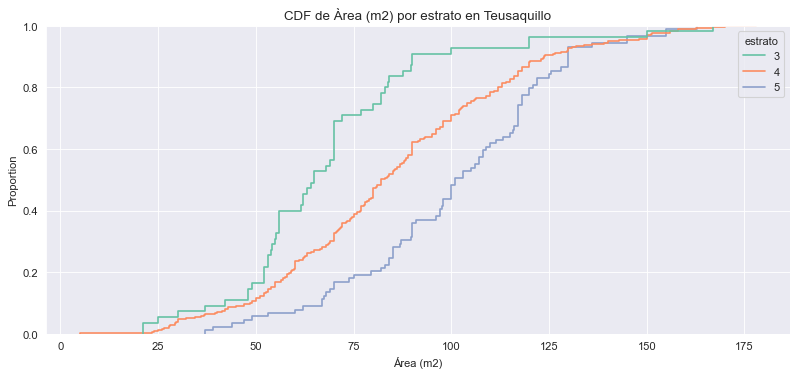

In [29]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    teusaquillo,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[3, 4, 5],
)

plt.title('CDF de Àrea (m2) por estrato en Teusaquillo')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [30]:
teusaquillo.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

count  mean   std   min   25%   50%    75%    max
antiguedad                                                           
ENTRE 0 Y 5 ANOS    142.0  64.7  25.1  21.0  50.5  68.5   80.0  132.0
ENTRE 10 Y 20 ANOS  149.0  93.4  28.4  37.0  76.0  90.0  113.0  167.0
ENTRE 5 Y 10 ANOS    74.0  75.9  28.5  30.0  54.2  72.0   90.0  150.0
MAS DE 20 ANOS      253.0  95.7  29.6   4.9  74.0  97.0  117.0  178.0
REMODELADO           23.0  98.5  21.1  53.0  82.5  96.0  117.0  145.0
SOBRE PLANOS          5.0  45.6  19.1  23.5  26.0  57.5   58.5   62.5

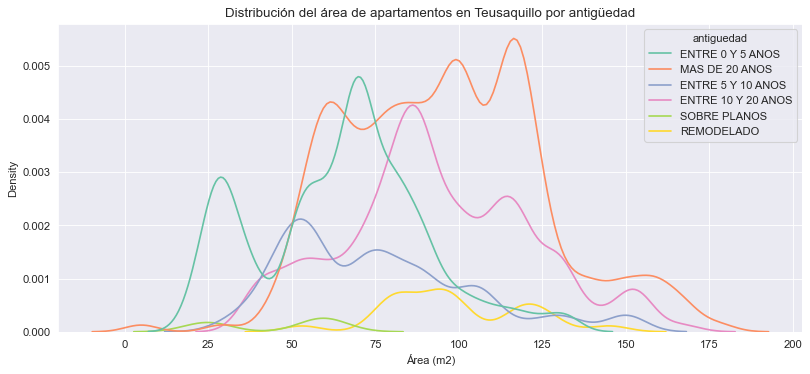

In [31]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Teusaquillo por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

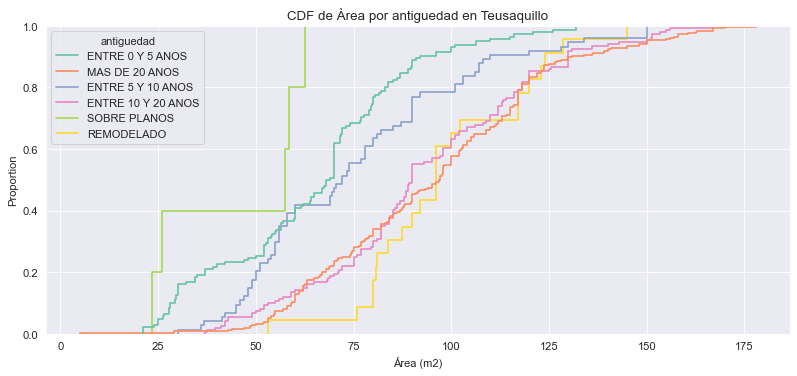

In [32]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    teusaquillo,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Teusaquillo')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [33]:
estacion_tm_cercana = teusaquillo[teusaquillo['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

count   mean   std   min   25%  \
estacion_tm_cercana                                                        
AV. ElDorado                               17.0  104.7  28.4  60.0  88.2   
Calle 26                                   16.0  100.9  54.7  24.0  47.0   
Campín - UAN                               65.0   97.4  34.8  28.0  73.8   
Salitre - El Greco                         11.0   93.2  18.3  67.0  82.5   
Gobernación                                 5.0   92.9  43.9  52.0  53.2   
Calle 45 - American School Way              3.0   88.0  34.4  50.0  73.5   
Movistar Arena                             24.0   84.2  34.3  21.0  61.0   
CAN                                        10.0   83.7   9.9  71.2  74.0   
Centro Memoria                             13.0   82.2  22.2  50.0  70.0   
Ciudad Universitaria - Lotería de Bogotá   16.0   80.7  27.0  30.0  59.0   
CAD                                        18.0   75.8  30.6  30.0  57.5   
Universidad Nacional                       25.0   73.0  33.5  21.0  54.0   
Calle 34                                   20.0   72.9  22.0  46.0  56.5   
Quinta Paredes                             19.0   72.0  21.7  47.0  50.5   
Corferias                                  30.0   70.1  16.3  30.0  61.3   
AV. 39                                      1.0   68.0   NaN  68.0  68.0   
Calle 63                                    7.0   66.9  17.6  56.0  56.0   
Marly                                      29.0   60.7  14.9  25.0  52.0   
Concejo de Bogotá                           8.0   58.4  28.3  23.5  47.9   
Calle 57                                   24.0   45.1  17.7  24.9  29.2   

                                            50%    75%    max  
estacion_tm_cercana                                            
AV. ElDorado                               95.0  126.7  167.0  
Calle 26                                  111.4  151.8  160.5  
Campín - UAN                               98.0  118.0  170.0  
Salitre - El Greco                         90.0   99.0  134.0  
Gobernación                                86.0  120.0  153.5  
Calle 45 - American School Way             97.0  107.0  117.0  
Movistar Arena                             88.0  104.2  178.0  
CAN                                        84.8   89.3   98.0  
Centro Memoria                             71.7   98.3  120.0  
Ciudad Universitaria - Lotería de Bogotá   82.8  102.6  125.6  
CAD                                        69.5   98.8  129.5  
Universidad Nacional                       62.0   95.0  143.0  
Calle 34                                   69.3   83.3  126.0  
Quinta Paredes                             70.4   90.2  110.0  
Corferias                                  70.0   76.9  118.0  
AV. 39                                     68.0   68.0   68.0  
Calle 63                                   56.0   72.3  100.0  
Marly                                      64.0   70.0   89.6  
Concejo de Bogotá                          58.0   64.1  115.0  
Calle 57                                   40.7   62.2   80.0

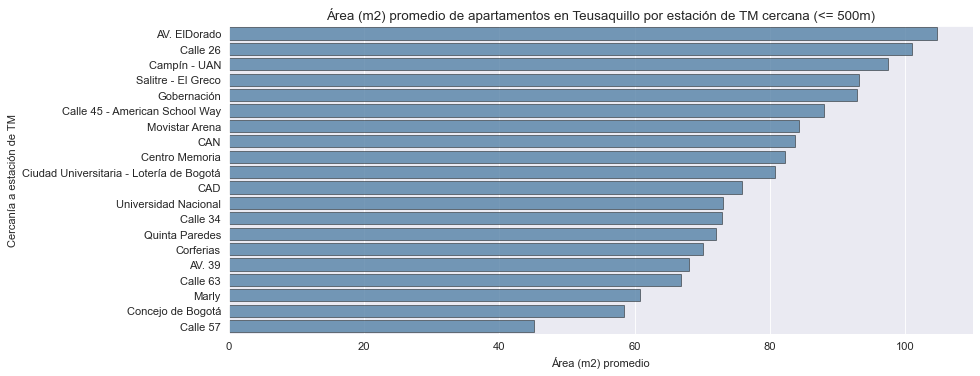

In [34]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Teusaquillo por estación de TM cercana (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [35]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

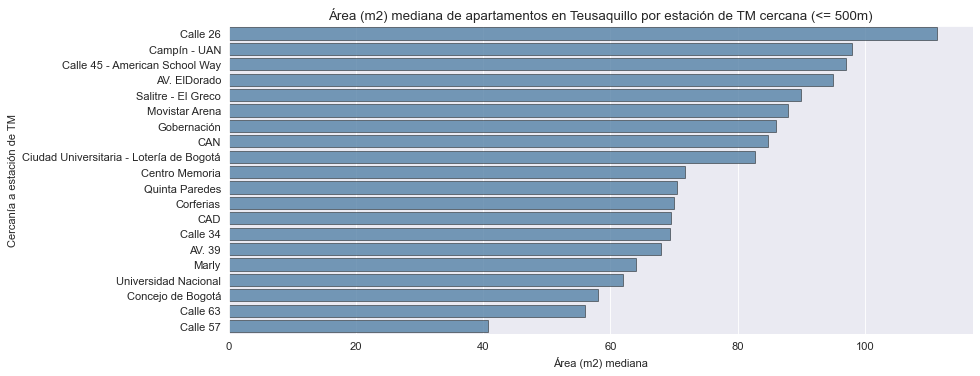

In [36]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Teusaquillo por estación de TM cercana (<= 500m)')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 960x400 with 0 Axes>

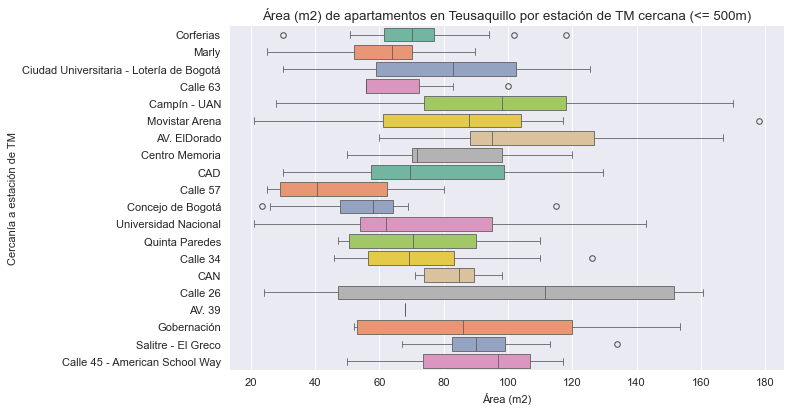

In [37]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Teusaquillo por estación de TM cercana (<= 500m)')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [78]:
MAPBOX_TOKEN = os.getenv('MAPBOX_TOKEN')

px.set_mapbox_access_token(MAPBOX_TOKEN)

fig = px.scatter_mapbox(
    teusaquillo,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    # mapbox_style='open-street-map',
    # mapbox_style='dark',
    title='Precio de venta y área de apartamentos en Teusaquillo',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
    mapbox=dict(
        style='basic',
    ),
)

fig.write_html('../../html/teusaquillo_precios_area.html')

fig.show()

In [40]:
teusaquillo.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

count           mean            std            min  \
precio_venta   646  569.5 million  199.2 million  237.0 million   

                        25%            50%            75%          max  
precio_venta  420.0 million  544.9 million  680.0 million  1.2 billion

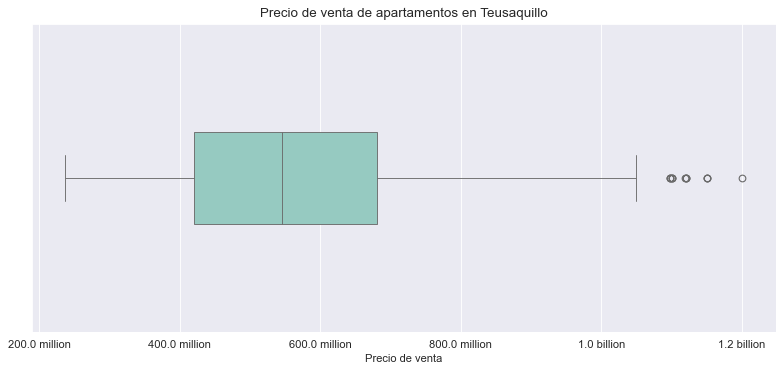

In [41]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    teusaquillo,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Teusaquillo')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

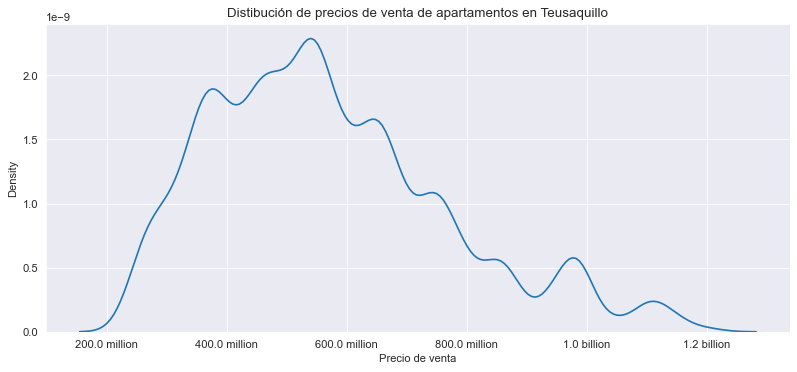

In [42]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Teusaquillo')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Barrios

In [43]:
top_barrios = teusaquillo.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 20].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                       
CIUDAD SALITRE SURORIENTAL    82  772.2 million  750.0 million  189.8 million
TEUSAQUILLO                   32  625.0 million  555.0 million  227.8 million
NICOLAS DE FEDERMAN           93  620.6 million  570.0 million  185.5 million
ORTEZAL - QUINTA PAREDES      26  574.5 million  501.0 million  193.7 million
BELALCAZAR                    26  510.2 million  471.5 million  204.0 million
CAMPIN OCCIDENTAL             25  489.4 million  495.0 million  148.8 million
QUINTA PAREDES                29  471.9 million  480.0 million   97.5 million
SAN LUIS                      24  445.7 million  420.0 million  133.7 million
CHAPINERO OCCIDENTAL          29  353.9 million  360.0 million   68.7 million

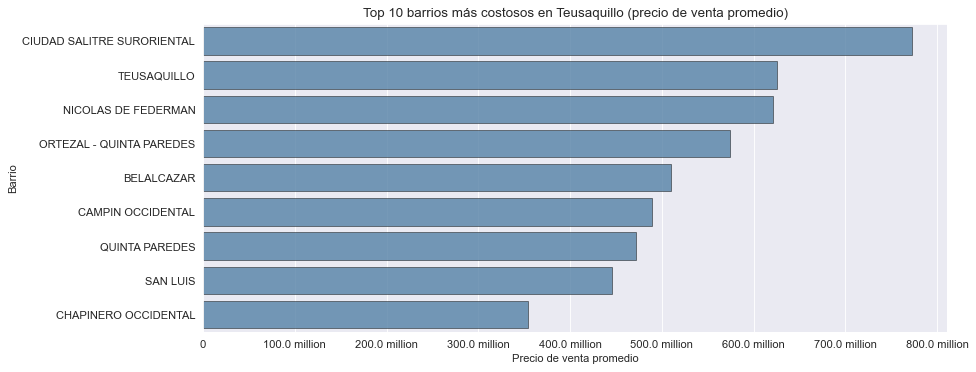

In [44]:
plt.figure(figsize=(12, 5), dpi=80)

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Teusaquillo (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [45]:
top_barrios_median = top_barrios[top_barrios['count'] > 20].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                       
CIUDAD SALITRE SURORIENTAL    82  772.2 million  750.0 million  189.8 million
NICOLAS DE FEDERMAN           93  620.6 million  570.0 million  185.5 million
TEUSAQUILLO                   32  625.0 million  555.0 million  227.8 million
ORTEZAL - QUINTA PAREDES      26  574.5 million  501.0 million  193.7 million
CAMPIN OCCIDENTAL             25  489.4 million  495.0 million  148.8 million
QUINTA PAREDES                29  471.9 million  480.0 million   97.5 million
BELALCAZAR                    26  510.2 million  471.5 million  204.0 million
SAN LUIS                      24  445.7 million  420.0 million  133.7 million
CHAPINERO OCCIDENTAL          29  353.9 million  360.0 million   68.7 million

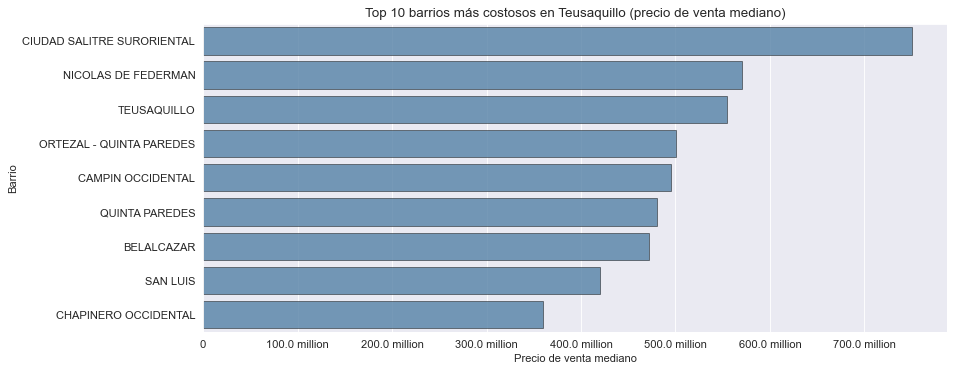

In [46]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Teusaquillo (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [47]:
top_barrios_economicos = teusaquillo.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                 
CHAPINERO OCCIDENTAL    29  353.9 million  360.0 million   68.7 million
QUESADA                 17  357.2 million  350.0 million   76.9 million
ALFONSO LOPEZ           16  390.4 million  395.0 million   98.2 million
SAN LUIS                24  445.7 million  420.0 million  133.7 million
BANCO CENTRAL           11  469.2 million  527.4 million   84.6 million
QUINTA PAREDES          29  471.9 million  480.0 million   97.5 million
SANTA CLARA             12  483.3 million  477.5 million  159.1 million
CAMPIN OCCIDENTAL       25  489.4 million  495.0 million  148.8 million
BELALCAZAR              26  510.2 million  471.5 million  204.0 million
ARMENIA                 17  514.9 million  550.0 million  166.6 million

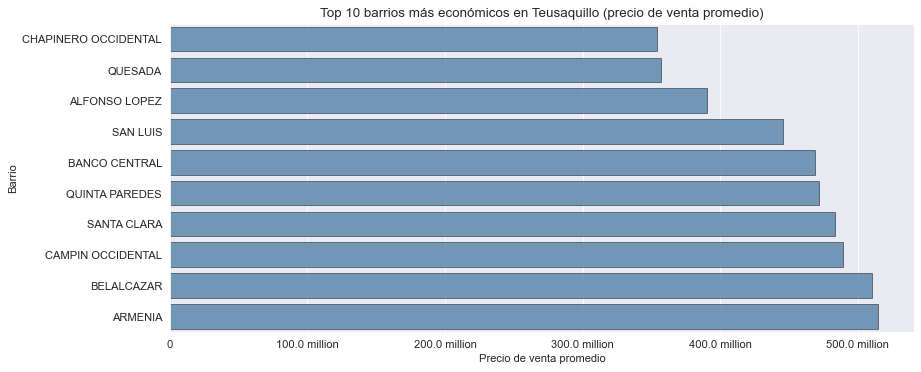

In [48]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Teusaquillo (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [49]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                     
QUESADA                     17  357.2 million  350.0 million   76.9 million
CHAPINERO OCCIDENTAL        29  353.9 million  360.0 million   68.7 million
ALFONSO LOPEZ               16  390.4 million  395.0 million   98.2 million
SAN LUIS                    24  445.7 million  420.0 million  133.7 million
BELALCAZAR                  26  510.2 million  471.5 million  204.0 million
SANTA CLARA                 12  483.3 million  477.5 million  159.1 million
QUINTA PAREDES              29  471.9 million  480.0 million   97.5 million
CAMPIN OCCIDENTAL           25  489.4 million  495.0 million  148.8 million
ORTEZAL - QUINTA PAREDES    26  574.5 million  501.0 million  193.7 million
EL_RECUERDO                 19  521.6 million  522.7 million  161.3 million

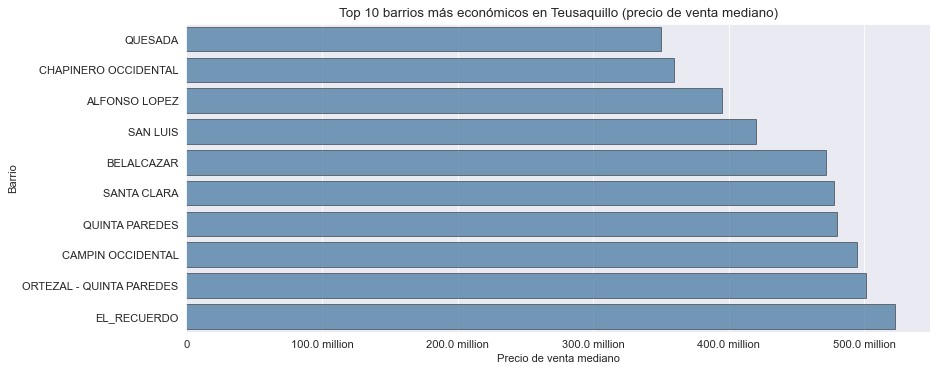

In [50]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Teusaquillo (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [51]:
teusaquillo.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

count                 mean                   std  \
is_cerca_estacion_tm                                                     
0                     285.0  630,674,901.0140351  197,999,487.24293968   
1                     361.0  521,273,242.3296399   186,809,921.4205334   

                                min            25%            50%  \
is_cerca_estacion_tm                                                
0                     260,000,000.0  500,000,000.0  600,000,000.0   
1                     237,000,000.0  385,000,000.0  480,000,000.0   

                                75%              max  
is_cerca_estacion_tm                                  
0                     750,000,000.0  1,200,000,000.0  
1                     620,000,000.0  1,120,000,000.0

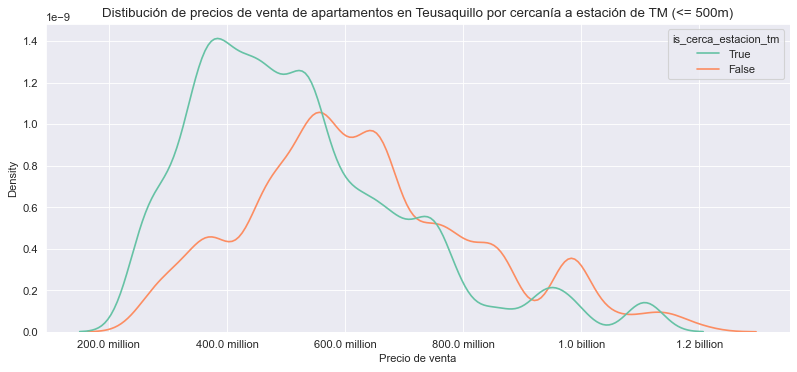

In [52]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Teusaquillo por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

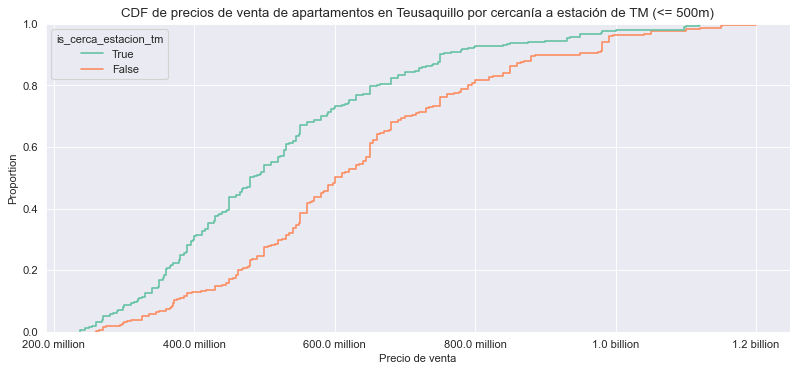

In [53]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    teusaquillo,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Teusaquillo por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [54]:
teusaquillo.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

count           mean            std            min            25%  \
estrato                                                                     
3.0        55  414.0 million   99.9 million  237.0 million  345.0 million   
4.0       502  569.4 million  195.1 million  245.0 million  420.0 million   
5.0        89  666.6 million  208.5 million  264.0 million  530.0 million   

                   50%            75%            max  
estrato                                               
3.0      411.5 million  465.0 million  630.0 million  
4.0      546.9 million  680.0 million    1.2 billion  
5.0      630.0 million  760.0 million    1.2 billion

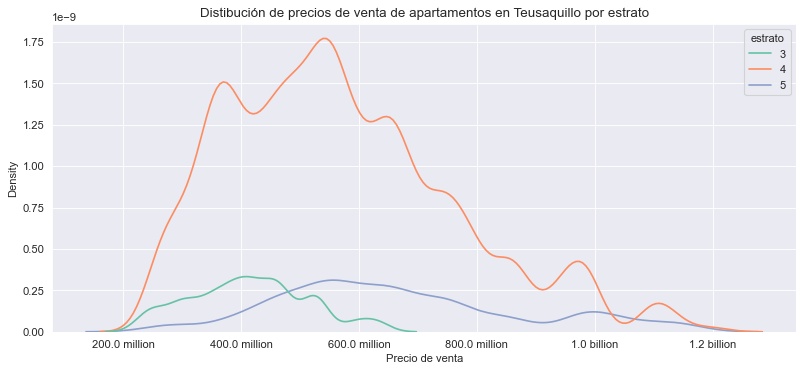

In [55]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[3, 4, 5],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Teusaquillo por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

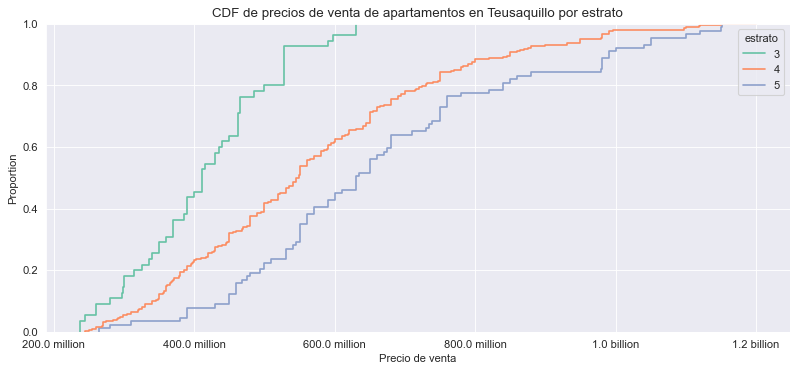

In [56]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    teusaquillo,
    x='precio_venta',
    hue='estrato',
    hue_order=[3, 4, 5],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Teusaquillo por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Antiguedad del apartamento

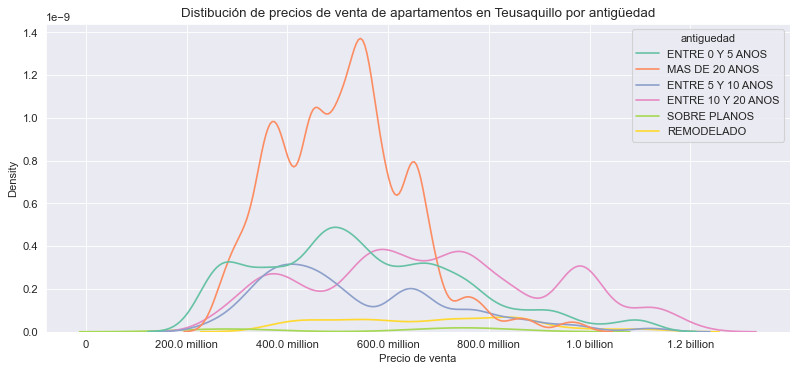

In [57]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    teusaquillo,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Teusaquillo por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

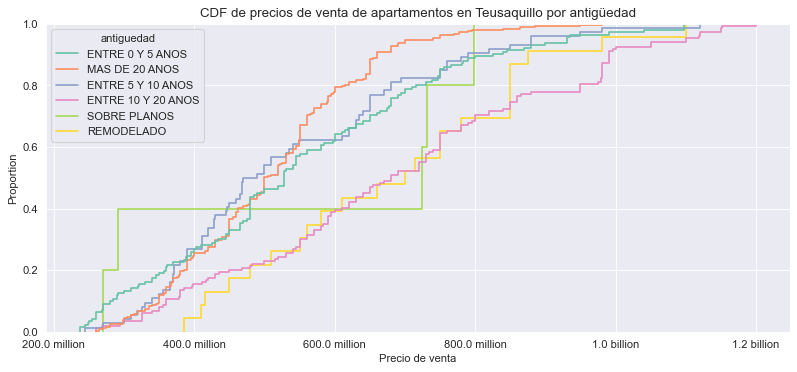

In [58]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    teusaquillo,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Teusaquillo por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [59]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

count           mean            std  \
estacion_tm_cercana                                                            
CAN                                         10  739.5 million  107.8 million   
Gobernación                                  5  709.6 million  310.4 million   
Ciudad Universitaria - Lotería de Bogotá    16  676.0 million  202.1 million   
Centro Memoria                              13  651.2 million  221.6 million   
Salitre - El Greco                          11  650.1 million  126.1 million   
Calle 34                                    20  596.3 million  235.0 million   
Campín - UAN                                65  566.4 million  214.4 million   
Concejo de Bogotá                            8  533.1 million  207.1 million   
Calle 26                                    16  522.7 million  168.8 million   
Quinta Paredes                              19  522.6 million  178.5 million   
CAD                                         18  519.8 million  124.6 million   
AV. ElDorado                                17  500.5 million  106.3 million   
Movistar Arena                              24  483.7 million  125.9 million   
Universidad Nacional                        25  474.0 million  173.4 million   
Corferias                                   30  467.5 million   96.8 million   
Calle 63                                     7  416.0 million   47.9 million   
Marly                                       29  406.6 million   93.1 million   
Calle 45 - American School Way               3  360.0 million   40.0 million   
AV. 39                                       1  350.0 million            NaN   
Calle 57                                    24  334.2 million   60.2 million   

                                                    min            25%  \
estacion_tm_cercana                                                      
CAN                                       595.0 million  682.5 million   
Gobernación                               430.0 million  449.0 million   
Ciudad Universitaria - Lotería de Bogotá  320.0 million  563.7 million   
Centro Memoria                            390.0 million  500.0 million   
Salitre - El Greco                        446.0 million  525.0 million   
Calle 34                                  330.0 million  410.0 million   
Campín - UAN                              260.0 million  430.0 million   
Concejo de Bogotá                         270.0 million  350.5 million   
Calle 26                                  250.0 million  386.0 million   
Quinta Paredes                            298.0 million  370.0 million   
CAD                                       350.0 million  418.2 million   
AV. ElDorado                              330.0 million  390.0 million   
Movistar Arena                            255.0 million  384.2 million   
Universidad Nacional                      237.0 million  357.0 million   
Corferias                                 280.0 million  446.2 million   
Calle 63                                  335.9 million  411.5 million   
Marly                                     245.0 million  340.0 million   
Calle 45 - American School Way            320.0 million  340.0 million   
AV. 39                                    350.0 million  350.0 million   
Calle 57                                  245.0 million  284.9 million   

                                                    50%            75%  \
estacion_tm_cercana                                                      
CAN                                       750.0 million  772.5 million   
Gobernación                               590.0 million  979.0 million   
Ciudad Universitaria - Lotería de Bogotá  645.0 million  758.8 million   
Centro Memoria                            600.0 million  680.0 million   
Salitre - El Greco                        700.0 million  750.0 million   
Calle 34                                  545.0 million  782.0 million   
Campín - UAN                              510.0 million  69

In [60]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

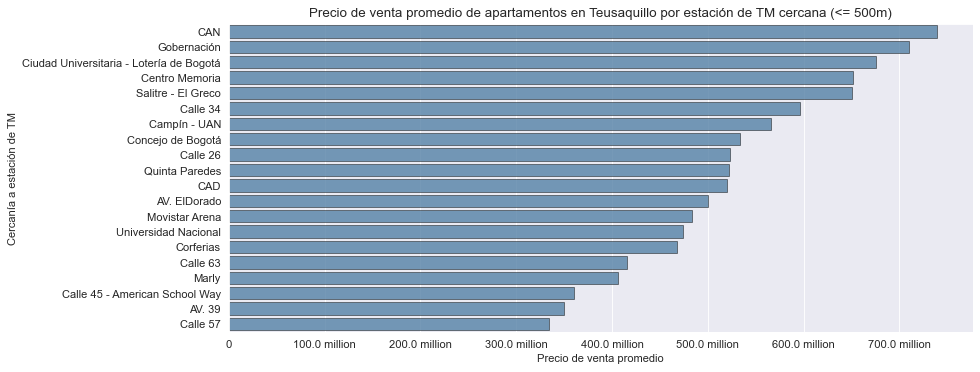

In [61]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Teusaquillo por estación de TM cercana (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

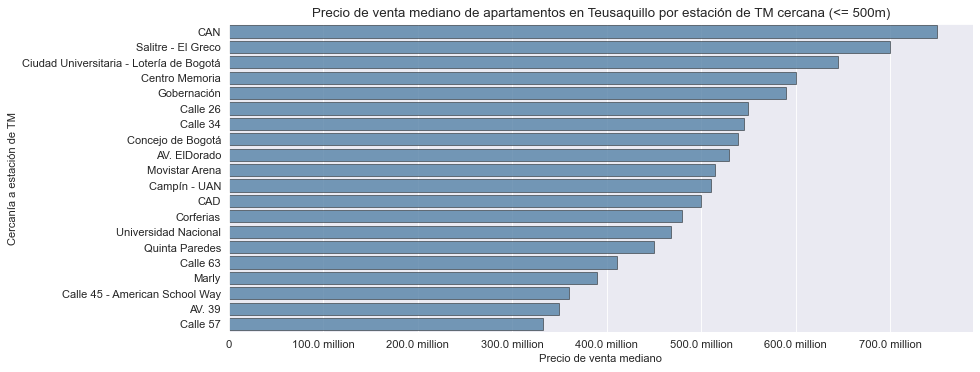

In [62]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Teusaquillo por estación de TM cercana (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

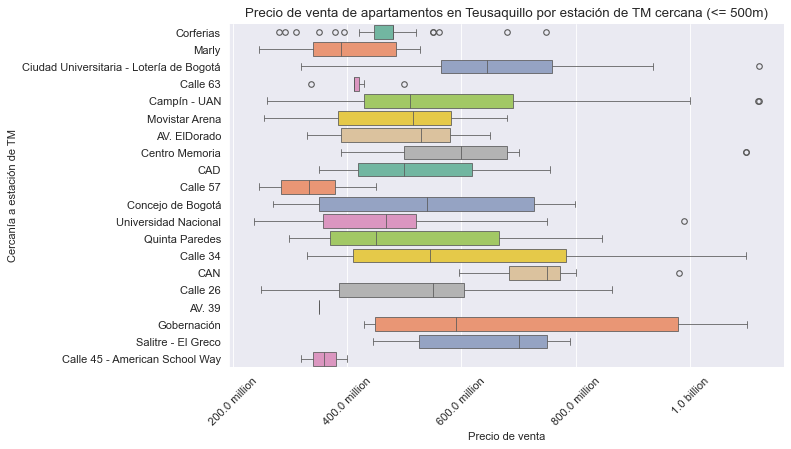

In [63]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Teusaquillo por estación de TM cercana (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.xticks(rotation=45)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

## Antiguedad

In [65]:
teusaquillo.antiguedad.value_counts()

antiguedad
MAS DE 20 ANOS        253
ENTRE 10 Y 20 ANOS    149
ENTRE 0 Y 5 ANOS      142
ENTRE 5 Y 10 ANOS      74
REMODELADO             23
SOBRE PLANOS            5
Name: count, dtype: int64

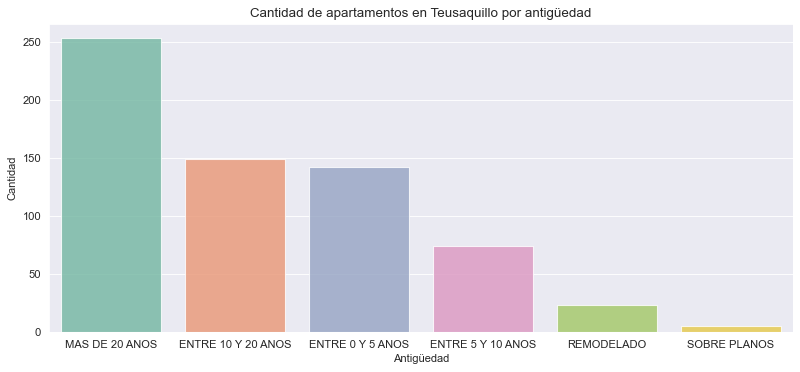

In [66]:
plt.figure(figsize=(12, 5))

sns.countplot(
    teusaquillo,
    x='antiguedad',
    order=teusaquillo.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en Teusaquillo por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.show()

### Barrios

In [67]:
teusaquillo.groupby('antiguedad')['barrio'].describe()

count unique                         top freq
antiguedad                                                      
ENTRE 0 Y 5 ANOS     142     21                 TEUSAQUILLO   20
ENTRE 10 Y 20 ANOS   149     28  CIUDAD SALITRE SURORIENTAL   59
ENTRE 5 Y 10 ANOS     74     20         NICOLAS DE FEDERMAN   20
MAS DE 20 ANOS       253     37         NICOLAS DE FEDERMAN   46
REMODELADO            23     15    ORTEZAL - QUINTA PAREDES    5
SOBRE PLANOS           5      1                LAS AMERICAS    5

In [68]:
teusaquillo.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

count  mean   std   min   25%   50%    75%    max
antiguedad                                                           
ENTRE 0 Y 5 ANOS    142.0  64.7  25.1  21.0  50.5  68.5   80.0  132.0
ENTRE 10 Y 20 ANOS  149.0  93.4  28.4  37.0  76.0  90.0  113.0  167.0
ENTRE 5 Y 10 ANOS    74.0  75.9  28.5  30.0  54.2  72.0   90.0  150.0
MAS DE 20 ANOS      253.0  95.7  29.6   4.9  74.0  97.0  117.0  178.0
REMODELADO           23.0  98.5  21.1  53.0  82.4  96.0  117.0  145.0
SOBRE PLANOS          5.0  45.6  19.1  23.5  26.0  57.5   58.5   62.5

In [69]:
teusaquillo.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

count unique                 top freq
barrio                                                          
NICOLAS DE FEDERMAN           93      5      MAS DE 20 ANOS   46
CIUDAD SALITRE SURORIENTAL    82      5  ENTRE 10 Y 20 ANOS   59
TEUSAQUILLO                   32      4    ENTRE 0 Y 5 ANOS   20
CHAPINERO OCCIDENTAL          29      4    ENTRE 0 Y 5 ANOS   12
QUINTA PAREDES                29      4    ENTRE 0 Y 5 ANOS   13
ORTEZAL - QUINTA PAREDES      26      4      MAS DE 20 ANOS   12
BELALCAZAR                    26      4  ENTRE 10 Y 20 ANOS   11
CAMPIN OCCIDENTAL             25      5      MAS DE 20 ANOS   11
SAN LUIS                      24      4      MAS DE 20 ANOS   15
GRAN AMERICA                  20      5    ENTRE 0 Y 5 ANOS    8

### Estrato

In [71]:
teusaquillo.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('estrato', 'mean'),
    median=('estrato', 'median'),
    std=('estrato', 'std'),
).sort_values(by='count', ascending=False).head(10)

count      mean  median       std
barrio                                                       
NICOLAS DE FEDERMAN            93  4.698925     5.0  0.461212
CIUDAD SALITRE SURORIENTAL     82  4.146341     4.0  0.355623
TEUSAQUILLO                    32  3.968750     4.0  0.176777
QUINTA PAREDES                 29  4.000000     4.0  0.000000
CHAPINERO OCCIDENTAL           29  3.655172     4.0  0.483725
BELALCAZAR                     26  3.961538     4.0  0.196116
ORTEZAL - QUINTA PAREDES       26  4.038462     4.0  0.196116
CAMPIN OCCIDENTAL              25  4.080000     4.0  0.276887
SAN LUIS                       24  3.958333     4.0  0.204124
GRAN AMERICA                   20  4.050000     4.0  0.223607

## Barrios

In [72]:
teusaquillo.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

codigo
barrio                            
NICOLAS DE FEDERMAN             93
CIUDAD SALITRE SURORIENTAL      82
TEUSAQUILLO                     32
QUINTA PAREDES                  29
CHAPINERO OCCIDENTAL            29
BELALCAZAR                      26
ORTEZAL - QUINTA PAREDES        26
CAMPIN OCCIDENTAL               25
SAN LUIS                        24
GRAN AMERICA                    20

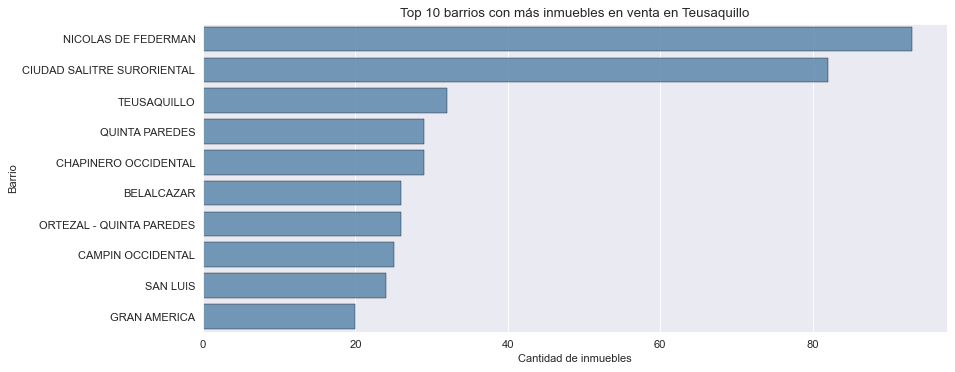

In [73]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=teusaquillo.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=teusaquillo.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Teusaquillo')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()

In [75]:
parque_cercano_stats = teusaquillo.groupby('parque_cercano')['precio_venta'].describe().sort_values('mean', ascending=False)
parque_cercano_stats

count          mean  \
parque_cercano                                                            
PARQUE METROPOLITANO PARQUE CENTRAL SIMÓN BOLÍVAR    41.0  8.278293e+08   
PARQUE ZONAL SAUZALITO                                8.0  7.541250e+08   
PARQUE VECINAL URBANIZACIÓN SALITRE (GRECO)          46.0  7.009565e+08   
PARQUE METROPOLITANO VIRGILIO BARCO                  10.0  6.355000e+08   
PARQUE ESCENARIO DEPORTIVO COMPLEJO ACUATICO         17.0  6.147647e+08   
PARQUE ZONAL NICOLAS DE FEDERMAN 3                   92.0  5.934537e+08   
PARQUE METROPOLITANO EL RENACIMIENTO - PARQUE C...  107.0  5.840582e+08   
PARQUE VECINAL SANTA CLARA                          122.0  5.566741e+08   
PARQUE ZONAL GIMNASIO DEL NORTE                      10.0  5.252397e+08   
PARQUE VECINAL ARENA MOVISTAR                        15.0  5.072667e+08   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD     152.0  4.646834e+08   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...   26.0  3.999423e+08   

                                                             std          min  \
parque_cercano                                                                  
PARQUE METROPOLITANO PARQUE CENTRAL SIMÓN BOLÍVAR   1.949759e+08  386000000.0   
PARQUE ZONAL SAUZALITO                              1.122961e+08  600000000.0   
PARQUE VECINAL URBANIZACIÓN SALITRE (GRECO)         1.488167e+08  446000000.0   
PARQUE METROPOLITANO VIRGILIO BARCO                 1.896554e+08  480000000.0   
PARQUE ESCENARIO DEPORTIVO COMPLEJO ACUATICO        1.918569e+08  280000000.0   
PARQUE ZONAL NICOLAS DE FEDERMAN 3                  1.532237e+08  264000000.0   
PARQUE METROPOLITANO EL RENACIMIENTO - PARQUE C...  1.956915e+08  250000000.0   
PARQUE VECINAL SANTA CLARA                          1.791816e+08  280000000.0   
PARQUE ZONAL GIMNASIO DEL NORTE                     1.717474e+08  298000000.0   
PARQUE VECINAL ARENA MOVISTAR                       1.708130e+08  255000000.0   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD     1.739081e+08  237000000.0   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...  1.078987e+08  245000000.0   

                                                            25%          50%  \
parque_cercano                                                                 
PARQUE METROPOLITANO PARQUE CENTRAL SIMÓN BOLÍVAR   650000000.0  850000000.0   
PARQUE ZONAL SAUZALITO                              717000000.0  742500000.0   
PARQUE VECINAL URBANIZACIÓN SALITRE (GRECO)         601250000.0  695000000.0   
PARQUE METROPOLITANO VIRGILIO BARCO                 521250000.0  555000000.0   
PARQUE ESCENARIO DEPORTIVO COMPLEJO ACUATICO        530000000.0  580000000.0   
PARQUE ZONAL NICOLAS DE FEDERMAN 3                  503750000.0  560000000.0   
PARQUE METROPOLITANO EL RENACIMIENTO - PARQUE C...  417500000.0  550000000.0   
PARQUE VECINAL SANTA CLARA                          445000000.0  520000000.0   
PARQUE ZONAL GIMNASIO DEL NORTE                     402875000.0  522500000.0   
PARQUE VECINAL ARENA MOVISTAR                       379500000.0  450000000.0   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD     359250000.0  430000000.0   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...  340000000.0  378500000.0   

                                                            75%           max  
parque_cercano                                                                 
PARQUE METROPOLITANO PARQUE CENTRAL SIMÓN BOLÍVAR   990000000.0  1.150000e+09  
PARQUE ZONAL SAUZALITO                              762500000.0  9.900000e+08  
PARQUE VECINAL URBANIZACIÓN SALITRE (GRECO)         750000000.0  1.100000e+09  
PARQUE METROPOLITANO VIRGILIO BARCO                 715000000.0  1.100000e+09  
PARQUE ESCENARIO DEPORTIVO COMPLEJO ACUATICO        650000000.0  1.151000e+09  
PARQUE ZONAL NICOLAS DE FEDERMAN 3                  650000000.0  1.040000e+09  
PARQUE METROPOLITANO EL RENACIMIENTO - PARQUE C...  680000000.0  1.120000e+09  
PARQUE VECINAL SANTA CLAR

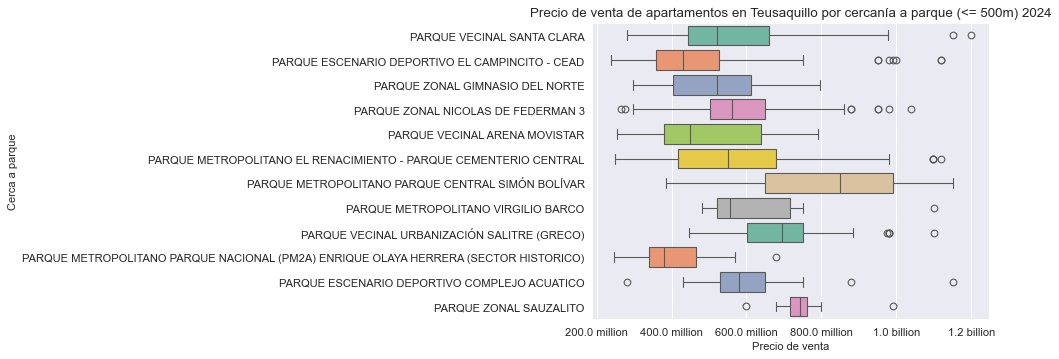

In [76]:
sns.boxplot(
    data=teusaquillo,
    x='precio_venta',
    y='parque_cercano',
    palette='Set2',
)

plt.title('Precio de venta de apartamentos en Teusaquillo por cercanía a parque (<= 500m) 2024')
plt.xlabel('Precio de venta')
plt.ylabel('Cerca a parque')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

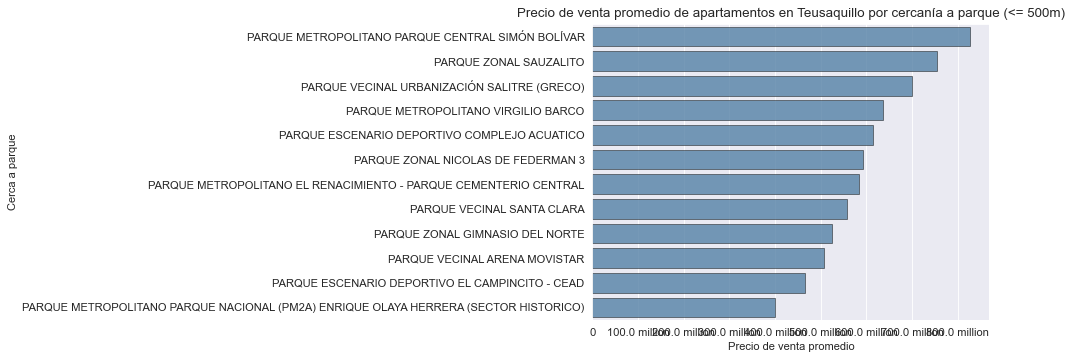

In [77]:
sns.barplot(
    data=parque_cercano_stats,
    x='mean',
    y=parque_cercano_stats.index,
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Teusaquillo por cercanía a parque (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cerca a parque')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()